# Co-training Algorithm Lisa Stuch

# 1. Imports, constants and global variables

In [13]:
from newsapi import NewsApiClient
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl

# Init
newsapi = NewsApiClient(api_key='7f176d0a1f1d456fb1bd2d3bf2540267')

list_of_sources = [("nbc-news","www.nbcnews.com"), 
                   ("cnn","www.cnn.com"), 
                   ("usa-today", "www.usatoday.com"), 
                   ("the-washington-times", "https://www.washingtontimes.com/"), 
                   ("new-york-magazine", "http://nymag.com"), 
                   ("politico", "https://www.politico.com"), 
                   ("the-huffington-post", "http://www.huffingtonpost.com"), 
                   ("vice-news", "https://news.vice.com"), 
                   ("al-jazeera-english", "http://www.aljazeera.com"),
                   ("abc-news", "https://abcnews.go.com"),
                   ("msnbc", "http://www.msnbc.com"),
                   ("newsweek", "https://www.newsweek.com"),
                   ("time", "http://time.com")
                  ]

    
dir_name = "/Users/lisastuch/Desktop/Archiv Samstag Abend/"

NEWS_COLUMN = "description"
URL_COLUMN = "url"
LABEL_COLUMN = "political"

# 2. Procurement and storage of the data in csv files (via newsapi)
# !!! This code was extracted from a code cell to a markdown cell because its execution changes the results !!!
The first csv files contains all retrieved messages with description (the summary of a news article) and the URL to the article on the news site. A fraction (20%) of the news are stored into three addional files: one for the news-summary (=description), one for the URLs and one with combination. The rows are chosen randomly. These files are the starting point for the semi supervised learning. In all three files the Y (political) is set to false.

The train and test data set are build manually from the "news_unclassified.csv"

```python
    list_of_df = []

    for source in list_of_sources:
        id, url = source

        news = newsapi.get_everything(sort_by='popularity', sources=id,
                                          domains=url)
        df = pd.DataFrame.from_dict(news["articles"])
        list_of_df.append(df)

    file_name = "all_news_unclassified.csv"

    df_all = pd.concat(list_of_df)
    df_filter_all = df_all.filter(items=["published at", NEWS_COLUMN, URL_COLUMN])


    df_filter_all.to_csv(dir_name + file_name)

    def split_dataframe(df, fraction):
        df_len = len(df)
        mask = np.random.RandomState(42).rand(df_len) < fraction
        df1 = df[mask]
        df2 = df[~mask]
        return df1, df2


    large_df, small_df = split_dataframe(df_filter_all, 0.80)

    large_df.to_csv(dir_name + "news_unclassified.csv")

    small_df[LABEL_COLUMN] = False
    small_df_description = small_df.filter(items=[NEWS_COLUMN, LABEL_COLUMN])
    small_df_description.to_csv(dir_name + "news_unclassified_manual_desc.csv")
    small_df_url = small_df.filter(items=[URL_COLUMN, LABEL_COLUMN])
    small_df_url.to_csv(dir_name + "news_unclassified_manual_url.csv")
```                                                                                  


# 3. Read training data and test data functions
The files copied from step 2 are renamed to four new files (for test and training separate files for the "description" (news text) and the URLs corresponding to the news. All 4 files are classified manually. This step is not shown in the notebook. 

In [7]:
import re

omit_list = ["http", "https", "www", "com", ""]

def filter_words(words, omit_words):
    return " ".join([word for word in words if word not in omit_words])    

def urls_to_words(urls):
    url_lines = [re.split("[/*-.:]",line) for line in urls]
    return [filter_words(line, omit_list) for line in url_lines]

        
def calculate_accuracy(model, cv, column, test_df, print_msg=True):
    failures = 0
    predictions = 0
    for index, row in test_df.iterrows():
        desc = row[column]
        polictial = row[LABEL_COLUMN]
        pred = model.predict(cv.transform([desc]))
        predictions +=1
        if pred[0] != polictial:
            failures += 1
    accuracy = (predictions - failures) / predictions
    if (print_msg):
        print(f"{failures} failures in {predictions} results in -> accuracy of {accuracy:.2%}")
    return accuracy

def read_train_data_from_csv_files(print_msg=True):
    train_desc_df = pd.read_csv(dir_name + "train_desc.csv")
    false_train_desc = train_desc_df[LABEL_COLUMN].value_counts(normalize=True)[0]
    train_url_df = pd.read_csv(dir_name + "train_url.csv")
    false_train_url = train_url_df[LABEL_COLUMN].value_counts(normalize=True)[0]
    X_desc = train_desc_df[NEWS_COLUMN].values.tolist()
    Y_desc = train_desc_df[LABEL_COLUMN].values.tolist()
    X_url = train_url_df[URL_COLUMN].values.tolist()
    Y_url = train_url_df[LABEL_COLUMN].values.tolist()
    if (print_msg):
        print(f"Read {len(X_desc)} news for training data.")
        print(f"{false_train_desc:.2%} of the values for the description are False.")
        print(f"{false_train_url:.2%} of the values for the URLs are False.")
    
    return (X_desc, Y_desc, X_url, Y_url)
    
def read_unclassified_data_from_csv(print_msg=True):
    uc_df = pd.read_csv(dir_name + "news_unclassified.csv")
    uc_descs = uc_df[NEWS_COLUMN].values.tolist()
    uc_urls = urls_to_words(uc_df[URL_COLUMN].values.tolist())
    if (print_msg):
        print(f"Read {len(uc_df)} unclassified news from csv file")
    return (uc_df, uc_descs, uc_urls)
    
    
def read_test_data_from_csv_files(print_msg=True):
    test_desc_df = pd.read_csv(dir_name + "test_news_desc.csv")
    false_test_desc = test_desc_df[LABEL_COLUMN].value_counts(normalize=True)[0]
    test_url_df = pd.read_csv(dir_name + "test_news_url.csv")
    false_test_url = test_url_df[LABEL_COLUMN].value_counts(normalize=True)[0]
    if (print_msg):
        print(f"Read {len(test_desc_df)} news for test data.")
        print(f"{false_test_desc:.2%} of the values for the description are False")
        print(f"{false_test_url:.2%} of the values for the URLs are False")

    return (test_desc_df,test_url_df )

# 4. Implementation of Naive Bayes Classifier

In [8]:
def del_unclassified(unclassified_df, index1, index2):
    if (index1 > index2):
        unclassified_df.drop(unclassified_df.index[index1], inplace = True)
        unclassified_df.drop(unclassified_df.index[index2], inplace = True)
    if (index2 > index1):
        unclassified_df.drop(unclassified_df.index[index2], inplace = True)
        unclassified_df.drop(unclassified_df.index[index1], inplace = True)
    if (index1 == index2):
         unclassified_df.drop(unclassified_df.index[index1], inplace = True)
    
    unclassified_df.reset_index(drop=True, inplace=True)

def train_naive_bayes(X, Y, U, column, conf_thres):
    # X = List containing description or URL string
    # Y = List containing values for Classification (politics True oder False)
    # U = List containing unclassified news (only description OR only url)
    # conf_thres = threshold for the confidence (traning stops if this threshold is reached)
    
    cv = CountVectorizer()
    cv.fit(X)
    X_transformed = cv.transform(X)
    model = MultinomialNB()
    model.fit(X_transformed, Y)
    
    pred = model.predict_proba(cv.transform(U[column]))
    pred_false = pred[:,0]
    max_false_index = np.argmax(pred_false)
    max_false_value = pred_false[max_false_index]
    min_false_index = np.argmin(pred_false)
    min_false_value = pred_false[min_false_index]
    
    X.append(U.iloc[min_false_index][column])
    Y.append(True)
    X.append(U.iloc[max_false_index][column])
    Y.append(False)
    
    confidence_too_low = False
    if (min_false_value > (1 - conf_thres)) or (max_false_value < conf_thres):
        confidence_too_low = True
    
    del_unclassified(U, max_false_index, min_false_index)

    return (model, cv, confidence_too_low)

class PoliticalClassifier:
    def __init__(self, model_a, countv_a, model_b, countv_b):
        self.m_a = model_a
        self.cv_a = countv_a
        self.m_b = model_b
        self.cv_b = countv_b
        
    def predict(self, description, url, combine_function):
        proba_a = self.m_a.predict_proba(self.cv_a.transform([description]))[:,1][0]
        a = self.m_a.predict(self.cv_a.transform([description]))
        proba_b = self.m_b.predict_proba(self.cv_b.transform([url]))[:,1][0]     
        b = self.m_b.predict(self.cv_b.transform([url]))
        combined_pred = combine_function(proba_a, proba_b)
        #print(f"Prediction {proba_a} {a} {proba_b} {b} -> {combined_pred}")
        return combined_pred
    
    def predict_average(self, description, url):
        return self.predict(description, url, lambda a, b: (a + b) / 2)
    
    def predict_max_prob(self, description, url):
        return self.predict(description, url, lambda a, b: a if a>=b else b)
    
    def predict_product(self, description, url):
        return self.predict(description, url, lambda a, b: a * b)
    
    def predict_product_normalize(self, description, url):
        return self.predict(description, url, lambda a, b: math.exp(math.log(a * b)))

# 5.1 Co-training (1st Variant)
Classifier A and Classifier B are being trained simultaneously (this is the version described in the paper)

In [9]:
def cotrain(X_desc, Y_desc, X_url, Y_url, unclass_df, conf_thres):
    print("Start training Classifier A and B - This might take a few seconds.")

    while len(unclass_df) >= 4:
        model_a, co_cv_a, conf_thres_A = train_naive_bayes(
            X_train_desc, Y_train_desc, unclass_df, NEWS_COLUMN, conf_thres)
        model_b, co_cv_b, conf_thres_B = train_naive_bayes(
            X_train_url, Y_train_url, unclass_df, URL_COLUMN, conf_thres)
        if (conf_thres_A or conf_thres_B):
            print(f"Stopped because confidence threshold was reached: {len(unclass_df)} unclassified documents")
            break

    print("*** Training was completed *** \n")
    
    return (model_a, co_cv_a, model_b, co_cv_b)


# Execute Co-training and calculate accuracy
X_train_desc, Y_train_desc, X_train_url, Y_train_url = read_train_data_from_csv_files()
unclassified_df, unclassified_descs, unclassified_urls = read_unclassified_data_from_csv()

co_class_a, co_cv_a, co_class_b, co_cv_b = cotrain(
    X_train_desc, Y_train_desc, X_train_url, Y_train_url, unclassified_df, 0.5)

co_train_cf = PoliticalClassifier(co_class_a, co_cv_a, co_class_b, co_cv_b)

print("Testing accuracy\n")
test_desc_df, test_url_df = read_test_data_from_csv_files()
accuracy_co_a = calculate_accuracy(co_class_a, co_cv_a, NEWS_COLUMN, test_desc_df)
accuracy_co_b = calculate_accuracy(co_class_b, co_cv_b, URL_COLUMN, test_url_df)
print("*** Done ***")

Read 125 news for training data.
57.60% of the values for the description are False.
64.80% of the values for the URLs are False.
Read 1075 unclassified news from csv file
Start training Classifier A and B - This might take a few seconds.
Stopped because confidence threshold was reached: 35 unclassified documents
*** Training was completed *** 

Testing accuracy

Read 86 news for test data.
69.77% of the values for the description are False
69.77% of the values for the URLs are False
16 failures in 86 results in -> accuracy of 81.40%
26 failures in 86 results in -> accuracy of 69.77%
*** Done ***


# 5.2 Two independent classifiers (2nd variant)
Classifier A and Classifier B are being trained independently

In [10]:
def train_successively(X_desc, Y_desc, X_url, Y_url, unclass_df, conf_thres):
    print("\nStart training Classifier A again - This might take a few seconds.")
    
    unclass_df_a = unclass_df;
    unclass_df_b = unclass_df.copy()
    
    while len(unclass_df_a[NEWS_COLUMN]) > 0:
        model_a, cv_a, conf_too_low = train_naive_bayes(X_desc, Y_desc, unclass_df_a, NEWS_COLUMN, conf_thres)
        if (conf_too_low):
            print(f"A: threshold {conf_thres:.2%} reached: {len(unclass_df[NEWS_COLUMN])} unclassified documents")
            break;

    print("Start training Classifier B")
    while len(unclass_df_b[URL_COLUMN]) > 0:
        model_b, cv_b, conf_too_low = train_naive_bayes(X_url, Y_url, unclass_df_b, URL_COLUMN, conf_thres)
        if (conf_too_low):
            print(f"B: threshold {conf_thres:.2%} reached: {len(unclass_df[URL_COLUMN])} unclassified documents")
            break;
    print("*** Training was completed *** \n")
    
    return (model_a, cv_a, model_b, cv_b)

# Execute Co-training and calculate accuracy
X_train_desc, Y_train_desc, X_train_url, Y_train_url = read_train_data_from_csv_files()
unclassified_df, unclassified_descs, unclassified_urls = read_unclassified_data_from_csv()

class_a, cv_a, class_b, cv_b = train_successively(
    X_train_desc, Y_train_desc, X_train_url, Y_train_url, unclassified_df, 0.8)

print("Testing accuracy\n")
test_desc_df, test_url_df = read_test_data_from_csv_files()
calculate_accuracy(class_a, cv_a, NEWS_COLUMN, test_desc_df)
calculate_accuracy(class_b, cv_b, URL_COLUMN, test_url_df)
print("*** Done ***")

Read 125 news for training data.
57.60% of the values for the description are False.
64.80% of the values for the URLs are False.
Read 1075 unclassified news from csv file

Start training Classifier A again - This might take a few seconds.
A: threshold 80.00% reached: 159 unclassified documents
Start training Classifier B
B: threshold 80.00% reached: 159 unclassified documents
*** Training was completed *** 

Testing accuracy

Read 86 news for test data.
69.77% of the values for the description are False
69.77% of the values for the URLs are False
22 failures in 86 results in -> accuracy of 74.42%
25 failures in 86 results in -> accuracy of 70.93%
*** Done ***


# 6.1. Accuracy for Co-Training with different thresholds
Accuracy for variant where classifiers are build simultaneously

In [11]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []

for t in thresholds:
    X_train_desc, Y_train_desc, X_train_url, Y_train_url = read_train_data_from_csv_files()
    test_desc_df, test_url_df = read_test_data_from_csv_files()
    u_df, u_descs, u_urls = read_unclassified_data_from_csv()
    print(f"\nTrain and calculate accuracy for {t} threshold")
    class_a, cv_a, class_b, cv_b = cotrain(
        X_train_desc, Y_train_desc, X_train_url, Y_train_url, u_df, t)
    accuracy_a = calculate_accuracy(class_a, cv_a, NEWS_COLUMN, test_desc_df)
    accuracy_b = calculate_accuracy(class_b, cv_b, URL_COLUMN, test_url_df)
    accuracies.append([accuracy_a, accuracy_b])
    print("\n--------------------------------------------------------")

Read 125 news for training data.
57.60% of the values for the description are False.
64.80% of the values for the URLs are False.
Read 86 news for test data.
69.77% of the values for the description are False
69.77% of the values for the URLs are False
Read 1075 unclassified news from csv file

Train and calculate accuracy for 0.1 threshold
Start training Classifier A and B - This might take a few seconds.
*** Training was completed *** 

16 failures in 86 results in -> accuracy of 81.40%
27 failures in 86 results in -> accuracy of 68.60%

--------------------------------------------------------
Read 125 news for training data.
57.60% of the values for the description are False.
64.80% of the values for the URLs are False.
Read 86 news for test data.
69.77% of the values for the description are False
69.77% of the values for the URLs are False
Read 1075 unclassified news from csv file

Train and calculate accuracy for 0.2 threshold
Start training Classifier A and B - This might take a 

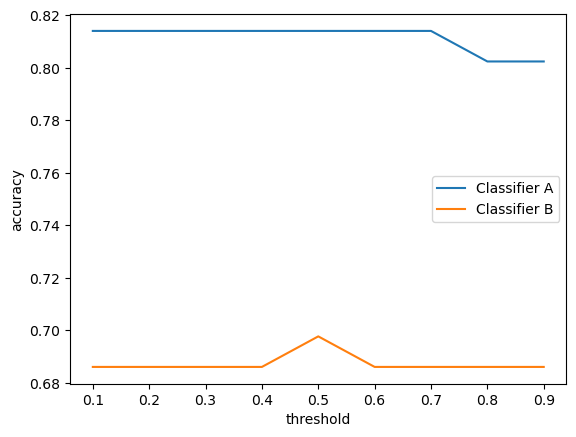

In [12]:
acc = np.array(accuracies)
plt.plot(thresholds, acc[:,0], label="Classifier A")
plt.plot(thresholds, acc[:,1], label="Classifier B")
plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend()
plt.show()

# 6.2. Accuracy for 2nd Variant with different thresholds
Accuracy for variant where classifiers are build successively

In [17]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []

for t in thresholds:
    X_train_desc, Y_train_desc, X_train_url, Y_train_url = read_train_data_from_csv_files(print_msg=False)
    test_desc_df, test_url_df = read_test_data_from_csv_files(print_msg=False)
    u_df, u_descs, u_urls = read_unclassified_data_from_csv(print_msg=False)
    print(f"\nTrain and calculate accuracy for {t} threshold")
    class_a, cv_a, class_b, cv_b = train_successively(
        X_train_desc, Y_train_desc, X_train_url, Y_train_url, u_df, t)
    accuracy_a = calculate_accuracy(class_a, cv_a, NEWS_COLUMN, test_desc_df, print_msg=False)
    accuracy_b = calculate_accuracy(class_b, cv_b, URL_COLUMN, test_url_df, print_msg=False)
    accuracies.append([accuracy_a, accuracy_b])
    print("\n--------------------------------------------------------")


Train and calculate accuracy for 0.1 threshold

Start training Classifier A again - This might take a few seconds.
Start training Classifier B
*** Training was completed *** 


--------------------------------------------------------

Train and calculate accuracy for 0.2 threshold

Start training Classifier A again - This might take a few seconds.
Start training Classifier B
*** Training was completed *** 


--------------------------------------------------------

Train and calculate accuracy for 0.3 threshold

Start training Classifier A again - This might take a few seconds.
Start training Classifier B
B: threshold 30.00% reached: 0 unclassified documents
*** Training was completed *** 


--------------------------------------------------------

Train and calculate accuracy for 0.4 threshold

Start training Classifier A again - This might take a few seconds.
Start training Classifier B
B: threshold 40.00% reached: 0 unclassified documents
*** Training was completed *** 


---------

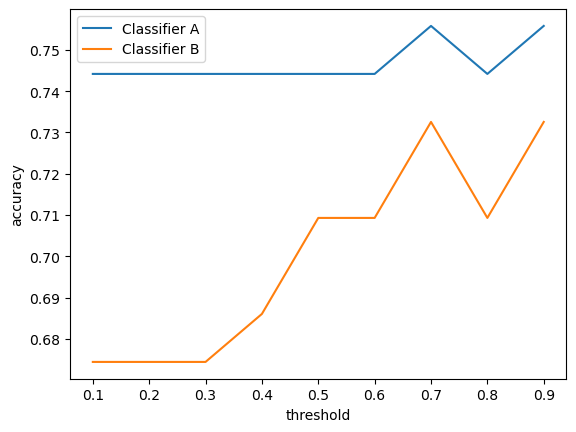

In [18]:
accu = np.array(accuracies)
plt.plot(thresholds, accu[:,0], label="Classifier A")
plt.plot(thresholds, accu[:,1], label="Classifier B")
plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [16]:
# check that test 
train_url_df = pd.read_csv(dir_name + "train_url.csv")
test_url_df = pd.read_csv(dir_name + "test_news_url.csv")
train_test_merge_df = pd.merge(test_url_df,train_url_df, how='inner')
if len(train_test_merge_df) == 0:
    print("test set OK")
else:
    print("*** Warning: test set and training set share some identical values ***")

test set OK


# 7 Accuracy for different combinations of co-training classifiers

In [19]:
def calculate_accuracy_combinations(classifier, test_df, print_msg=True):
    print(f"Accuracy co-training classifier A {accuracy_co_a}")
    print(f"Accuracy co-training classifier B {accuracy_co_b}")
    print("**********************************")
    
    failures = 0
    predictions = 0
    
    for index, row in test_df.iterrows():
        y_pred = classifier.predict_average(row[NEWS_COLUMN], row[URL_COLUMN]) > 0.5
        y_truth = row[LABEL_COLUMN]
        predictions +=1
        if y_pred != y_truth:
            failures += 1
    accuracy = (predictions - failures) / predictions
    
    accuracy_average = accuracy
    print(f"Accuracy average {accuracy_average}")
    failures = 0
    predictions = 0
    
    for index, row in test_df.iterrows():
        y_pred = classifier.predict_max_prob(row[NEWS_COLUMN], row[URL_COLUMN]) > 0.5
        y_truth = row[LABEL_COLUMN]
        predictions +=1
        if y_pred != y_truth:
            failures += 1
    accuracy = (predictions - failures) / predictions
    
    accuracy_max_prob = accuracy
    print(f"Accuracy max prob {accuracy_max_prob}")
    failures = 0
    predictions = 0
    
    for index, row in test_df.iterrows():
        y_pred = classifier.predict_product(row[NEWS_COLUMN], row[URL_COLUMN]) > 0.5
        y_truth = row[LABEL_COLUMN]
        predictions +=1
        if y_pred != y_truth:
            failures += 1
    accuracy = (predictions - failures) / predictions
    
    
    for index, row in test_df.iterrows():
        y_pred = classifier.predict_product_normalize(row[NEWS_COLUMN], row[URL_COLUMN]) > 0.5
        y_truth = row[LABEL_COLUMN]
        predictions +=1
        if y_pred != y_truth:
            failures += 1
    accuracy = (predictions - failures) / predictions
    
    accuracy_product_normalize = accuracy
    print(f"Accuracy product {accuracy_product_normalize}")
    failures = 0
    predictions = 0
       

test_df = pd.read_csv(dir_name + "test_news.csv")

c = PoliticalClassifier(co_class_a, co_cv_a, co_class_b, co_cv_b)
result = c.predict_average(test_desc_df.iloc[2][NEWS_COLUMN], test_url_df.iloc[2][URL_COLUMN])
calculate_accuracy_combinations(c, test_df)

Accuracy co-training classifier A 0.813953488372093
Accuracy co-training classifier B 0.6976744186046512
**********************************
Accuracy average 0.7558139534883721
Accuracy max prob 0.6627906976744186
Accuracy product 0.8255813953488372
